## Discover Sionna

This example notebook will guide you through the basic principles and illustrates the key features of [Sionna](https://nvlabs.github.io/sionna).
With only a few commands, you can simulate the PHY-layer link-level performance for many 5G-compliant components, including easy visualization of the results.


`PHY-layer link-level`（物理层链路水平）是指在网络通信中，涉及到物理层和链路层的一种通信水平或协议。这个术语通常用于描述网络协议栈中不同层次的通信功能和责任。

具体来说，PHY-layer link-level 包含以下几个方面：

1. **物理层（PHY Layer）**：负责在网络设备之间传输原始比特流，处理信号传输、调制解调、信道编解码等功能。物理层的任务是将数字信号转换为模拟信号（调制），在物理媒介上进行传输，然后再将模拟信号转换回数字信号（解调）。

2. **链路层（Link Layer）**：负责在相邻节点之间建立、管理和维护数据链路，处理数据帧的传输、流量控制、错误检测和纠正等功能。链路层的任务是确保可靠的点对点通信，并通过帧的发送和接收来处理数据的传输。

在PHY-layer link-level中，物理层和链路层密切合作，共同实现数据的传输和通信。物理层负责将数据转换为适合在物理媒介上传输的形式，而链路层负责将这些数据封装成数据帧，并通过物理链路传输到目的地。

这种分层结构有助于提高网络通信的灵活性和可靠性，同时也使得不同层次的功能更易于管理和维护。PHY-layer link-level的实现通常依赖于特定的通信协议和硬件设备，例如以太网、Wi-Fi、蓝牙等。

### Load Required Packages

The Sionna python package must be [installed](https://nvlabs.github.io/sionna/installation.html).

设置环境并导入包

In [1]:
import os
gpu_num = 0 # Use "" to use the CPU
# 设置环境变量，目的是将变量 gpu_num 所指定的GPU设备编号（通常是一个整数）作为字符串赋值给 CUDA_VISIBLE_DEVICES 环境变量，以便在运行CUDA应用程序时指定使用的GPU设备
os.environ["CUDA_VISIBLE_DEVICES"] = f"{gpu_num}"
# TF_CPP_MIN_LOG_LEVEL'：是TensorFlow中的一个环境变量，用于控制TensorFlow的日志输出级别
# 设置为 '3'，意味着只会输出ERROR和FATAL级别的日志信息
os.environ['TF_CPP_MIN_LOG_LEVEL'] = '3'

# Import Sionna
try:
    import sionna
except ImportError as e:
    # Install Sionna if package is not already installed
    import os
    os.system("pip install sionna")
    import sionna

import numpy as np
import tensorflow as tf
# Avoid warnings from TensorFlow
tf.get_logger().setLevel('ERROR')

# IPython "magic function" for inline plots
%matplotlib inline
import matplotlib.pyplot as plt

**Tip**: you can run bash commands in Jupyter via the `!` operator.

In [2]:
!nvidia-smi

Fri Jun 14 21:11:13 2024       
+---------------------------------------------------------------------------------------+
| NVIDIA-SMI 535.129.03             Driver Version: 535.129.03   CUDA Version: 12.2     |
|-----------------------------------------+----------------------+----------------------+
| GPU  Name                 Persistence-M | Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp   Perf          Pwr:Usage/Cap |         Memory-Usage | GPU-Util  Compute M. |
|                                         |                      |               MIG M. |
|=========================================+======================+======================|
|   0  NVIDIA GeForce RTX 4090        On  | 00000000:99:00.0 Off |                  Off |
| 30%   40C    P2             173W / 450W |  23104MiB / 24564MiB |     55%      Default |
|                                         |                      |                  N/A |
+-----------------------------------------+----------------------+--

In case multiple GPUs are available, we restrict this notebook to single-GPU usage. You can ignore this command if only one GPU is available.

Further, we want to avoid that this notebook instantiates the whole GPU memory when initialized and set `memory_growth` as active.

*Remark*: Sionna does not require a GPU. Everything can also run on your CPU - but you may need to wait a little longer.

用于展示可用的GPU的数量及编号

In [3]:
# Configure the notebook to use only a single GPU and allocate only as much memory as needed
# For more details, see https://www.tensorflow.org/guide/gpu
gpus = tf.config.list_physical_devices('GPU')
print('Number of GPUs available :', len(gpus))
if gpus:
    gpu_num = 0 # Index of the GPU to be used
    try:
        #tf.config.set_visible_devices([], 'GPU')
        tf.config.set_visible_devices(gpus[gpu_num], 'GPU')
        print('Only GPU number', gpu_num, 'used.')
        tf.config.experimental.set_memory_growth(gpus[gpu_num], True)
    except RuntimeError as e:
        print(e)

Number of GPUs available : 1
Only GPU number 0 used.


### Sionna Data-flow and Design Paradigms

Sionna inherently parallelizes simulations via *batching*, i.e., each element in the batch dimension is simulated independently.

This means the first tensor dimension is always used for *inter-frame* parallelization similar to an outer *for-loop* in Matlab/NumPy simulations.

To keep the dataflow efficient, Sionna follows a few simple design principles:

* Signal-processing components are implemented as an individual [Keras layer](https://keras.io/api/layers/).
* `tf.float32` is used as preferred datatype and `tf.complex64` for complex-valued datatypes, respectively.  
This allows simpler re-use of components (e.g., the same scrambling layer can be used for binary inputs and LLR-values).
* Models can be developed in *eager mode* allowing simple (and fast) modification of system parameters.
* Number crunching simulations can be executed in the faster *graph mode* or even *XLA* acceleration is available for most components.
* Whenever possible, components are automatically differentiable via [auto-grad](https://www.tensorflow.org/guide/autodiff) to simplify the deep learning design-flow.
* Code is structured into sub-packages for different tasks such as channel coding, mapping,... (see [API documentation](https://nvlabs.github.io/sionna/api/sionna.html) for details).

The division into individual blocks simplifies deployment and all layers and functions comes with unittests to ensure their correct behavior.

These paradigms simplify the re-useability and reliability of our components for a wide range of communications related applications.

### Let's Get Started - The First Layers (*Eager Mode*)

Every layer needs to be initialized once before it can be used.

**Tip**: use the [API documentation](https://nvlabs.github.io/sionna/api/sionna.html) to find an overview of all existing components.

We now want to transmit some symbols over an AWGN channel.
First, we need to initialize the corresponding layer.

In [4]:
channel = sionna.channel.AWGN() # init AWGN channel layer

In this first example, we want to add Gaussian noise to some given values of `x`.

Remember - the first dimension is the *batch-dimension*.

We simulate 2 message frames each containing 4 symbols.

*Remark*: the [AWGN channel](https://nvlabs.github.io/sionna/api/channel.html#awgn) is defined to be complex-valued.

In [5]:
# define a (complex-valued) tensor to be transmitted
x = tf.constant([[0., 1.5, 1., 0.],[-1., 0., -2, 3 ]], dtype=tf.complex64)

# let's have look at the shape
print("Shape of x: ", x.shape)
print("Values of x: ", x)

Shape of x:  (2, 4)
Values of x:  tf.Tensor(
[[ 0. +0.j  1.5+0.j  1. +0.j  0. +0.j]
 [-1. +0.j  0. +0.j -2. +0.j  3. +0.j]], shape=(2, 4), dtype=complex64)


We want to simulate the channel at an SNR of 5 dB.
For this, we can simply *call* the previously defined layer `channel`.

If you have never used  [Keras](https://keras.io) you can think of a layer as of a function: it has an input and returns the processed output.

*Remark*: Each time this cell is executed a new noise realization is drawn.

In [6]:
ebno_db = 5

# calculate noise variance from given EbNo
no = sionna.utils.ebnodb2no(ebno_db = ebno_db,
                            num_bits_per_symbol=2, # QPSK
                            coderate=1) 
y = channel([x, no])

print("Noisy symbols are: ", y)

Noisy symbols are:  tf.Tensor(
[[ 0.31495026-0.32261845j  1.7539729 +0.1601752j   0.9782761 -0.23446698j
  -0.03831759-0.11075902j]
 [-0.5892213 -0.06649271j -0.00448244+0.06422676j -1.8331838 +0.41748914j
   2.7026768 +0.211327j  ]], shape=(2, 4), dtype=complex64)


### Batches and Multi-dimensional Tensors

Sionna natively supports multi-dimensional tensors.

Most layers operate at the last dimension and can have arbitrary input shapes (preserved at output).

Let us assume we want to add a CRC-24 check to 64 codewords of length 500 (e.g., different CRC per sub-carrier).
Further, we want to parallelize the simulation over a batch of 100 samples.

In [7]:
batch_size = 100 # outer level of parallelism
num_codewords = 64 # codewords per batch sample
info_bit_length = 500 # info bits PER codeword

source = sionna.utils.BinarySource() # yields random bits

u = source([batch_size, num_codewords, info_bit_length]) # call the source layer
print("Shape of u: ", u.shape)

# initialize an CRC encoder with the standard compliant "CRC24A" polynomial
encoder_crc = sionna.fec.crc.CRCEncoder("CRC24A")
decoder_crc = sionna.fec.crc.CRCDecoder(encoder_crc) # connect to encoder

# add the CRC to the information bits u
c = encoder_crc(u) # returns a list [c, crc_valid]
print("Shape of c: ", c.shape)
print("Processed bits: ", np.size(c.numpy()))

# we can also verify the results
# returns list of [info bits without CRC bits, indicator if CRC holds]
u_hat, crc_valid = decoder_crc(c) 
print("Shape of u_hat: ", u_hat.shape)
print("Shape of crc_valid: ", crc_valid.shape)

print("Valid CRC check of first codeword: ", crc_valid.numpy()[0,0,0])

Shape of u:  (100, 64, 500)
Shape of c:  (100, 64, 524)
Processed bits:  3353600
Shape of u_hat:  (100, 64, 500)
Shape of crc_valid:  (100, 64, 1)
Valid CRC check of first codeword:  True


We want to do another simulation but for 5 independent users.

Instead of defining 5 different tensors, we can simply add another dimension.

In [8]:
num_users = 5

u = source([batch_size, num_users, num_codewords, info_bit_length]) 
print("New shape of u: ", u.shape)

# We can re-use the same encoder as before
c = encoder_crc(u)
print("New shape of c: ", c.shape)
print("Processed bits: ", np.size(c.numpy()))

New shape of u:  (100, 5, 64, 500)
New shape of c:  (100, 5, 64, 524)
Processed bits:  16768000


Often a good visualization of results helps to get new research ideas.
Thus, Sionna has built-in plotting functions.

Let's have look at a 16-QAM constellation.

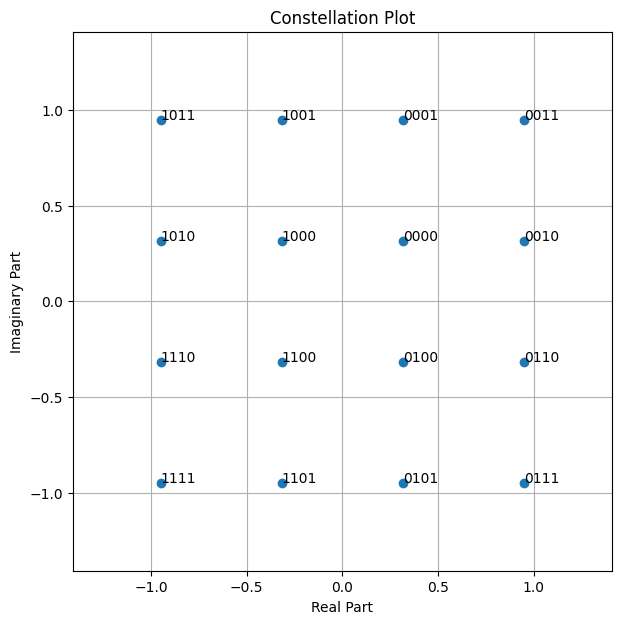

In [9]:
constellation = sionna.mapping.Constellation("qam", num_bits_per_symbol=4)
constellation.show();

### First Link-level Simulation

We can already build powerful code with a few simple commands.

As mentioned earlier, Sionna aims at hiding system complexity into Keras layers.
However, we still want to provide as much flexibility as possible.
Thus, most layers have several choices of init parameters, but often the default choice is a good start.

**Tip**: the [API documentation](https://nvlabs.github.io/sionna/api/sionna.html) provides many helpful references and implementation details.

- 关于`LDPC`的一篇博客：[LDPC码（一种前向纠错码）：基础 & 译码算法](https://zhuanlan.zhihu.com/p/514670102)

In [10]:
# system parameters
n_ldpc = 500 # LDPC codeword length 
k_ldpc = 250 # number of info bits per LDPC codeword
coderate = k_ldpc / n_ldpc
num_bits_per_symbol = 4 # number of bits mapped to one symbol (cf. QAM)

Often, several different algorithms are implemented, e.g., the demapper supports  *"true app"* demapping, but also *"max-log"* demapping.

The check-node (CN) update function of the LDPC BP decoder also supports multiple algorithms.

In [11]:
demapping_method = "app" # try "max-log"
ldpc_cn_type = "boxplus" # try also "minsum"

Let us initialize all required components for the given system parameters.

这段代码中涉及了通信系统中常见的一些组件和操作，下面详细解释一下每个部分的作用：

1. `binary_source = sionna.utils.BinarySource()`：创建了一个二进制源，用于生成随机的二进制比特序列，作为通信系统的输入数据。

2. `encoder = sionna.fec.ldpc.encoding.LDPC5GEncoder(k_ldpc, n_ldpc)`：创建了一个 LDPC 编码器，这里使用了 LDPC5GEncoder 类来进行 LDPC 编码。`k_ldpc` 表示每个 LDPC 码字中的信息比特数量，`n_ldpc` 表示 LDPC 码字的长度。

3. `constellation = sionna.mapping.Constellation("qam", num_bits_per_symbol)`：创建了一个调制方式为 QAM（Quadrature Amplitude Modulation，正交振幅调制）的星座图。`num_bits_per_symbol` 表示每个符号中的比特数量，用于确定 QAM 星座图中每个符号可以表示的状态数量。

4. `mapper = sionna.mapping.Mapper(constellation=constellation)`：创建了一个映射器，用于将输入比特序列映射到 QAM 星座图中的符号。

5. `channel = sionna.channel.AWGN()`：创建了一个加性白噪声（AWGN）信道模型，用于模拟信号传输过程中的噪声影响。

6. `demapper = sionna.mapping.Demapper(demapping_method, constellation=constellation)`：创建了一个解映射器，用于将接收到的符号映射回比特序列。`demapping_method` 参数指定了解调方法，这里根据之前的设定选择了 APP（Approximate Posterior Probability，近似后验概率）译码方法。

7. `decoder = sionna.fec.ldpc.decoding.LDPC5GDecoder(encoder, hard_out=True, cn_type=ldpc_cn_type, num_iter=20)`：创建了一个 LDPC 译码器，使用 LDPC5GDecoder 类。`encoder` 参数指定了编码器，`hard_out=True` 表示译码输出为硬判决结果，`cn_type=ldpc_cn_type` 指定了校验节点计算方法（这里根据之前的设定选择了 Box-Plus 算法），`num_iter=20` 表示进行译码的最大迭代次数。

综合起来，这段代码构建了一个基于 LDPC 编码的通信系统，包括了数据源生成、LDPC 编码、星座图映射、信道模拟、解映射、LDPC 译码等一系列组件，用于模拟和实现 LDPC 码字的传输和译码过程。

In [12]:
binary_source = sionna.utils.BinarySource()
encoder = sionna.fec.ldpc.encoding.LDPC5GEncoder(k_ldpc, n_ldpc)
constellation = sionna.mapping.Constellation("qam", num_bits_per_symbol)
mapper = sionna.mapping.Mapper(constellation=constellation)
channel = sionna.channel.AWGN()
demapper = sionna.mapping.Demapper(demapping_method,
                                   constellation=constellation)
decoder = sionna.fec.ldpc.decoding.LDPC5GDecoder(encoder,
                                                 hard_out=True, cn_type=ldpc_cn_type,
                                                 num_iter=20)

We can now run the code in *eager mode*. This allows us to modify the structure at any time - you can try a different `batch_size` or a different SNR `ebno_db`.

这段代码实现了一个 LDPC 码字的通信系统仿真过程，并计算了误比特率（BER）以评估系统的性能。下面对代码中的各部分进行解释：

1. `batch_size = 1000`：设置了每批次的数据量，即每次传输的 LDPC 码字数量。

2. `ebno_db = 4`：设置了信噪比（Eb/N0，信号能量与噪声功率比）为 4 dB，用于模拟信道的信噪比情况。

3. `b = binary_source([batch_size, k_ldpc])`：生成了一个随机比特序列批次，大小为 `[batch_size, k_ldpc]`，用作 LDPC 码字的输入。

4. `c = encoder(b)`：对输入比特序列进行 LDPC 编码，生成 LDPC 码字序列 `c`。

5. `x = mapper(c)`：将 LDPC 码字映射到星座图中的符号序列 `x`，这里使用了之前创建的映射器 `mapper`。

6. `no = sionna.utils.ebnodb2no(ebno_db, num_bits_per_symbol, coderate)`：根据给定的信噪比参数，计算了 AWGN 信道的噪声功率。

7. `y = channel([x, no])`：将映射后的符号序列 `x` 通过加性白噪声（AWGN）信道模拟传输，得到接收端的符号序列 `y`。

8. `llr = demapper([y, no])`：对接收到的符号序列 `y` 进行解映射，得到对数似然比（LLR）序列 `llr`，这里使用了之前创建的解映射器 `demapper`。

9. `b_hat = decoder(llr)`：利用得到的 LLR 序列进行 LDPC 译码，得到译码后的比特序列 `b_hat`，这里使用了之前创建的 LDPC 译码器 `decoder`。

10. 计算误比特率（BER）：
   - `c_hat = tf.cast(tf.less(0.0, llr), tf.float32)`：将 LLR 序列进行硬判决，得到解调器在译码前的硬判决比特序列 `c_hat`。
   - `ber_uncoded = sionna.utils.metrics.compute_ber(c, c_hat)`：计算未经编码的比特序列与硬判决比特序列之间的误比特率，用于评估解调器的性能。
   - `ber_coded = sionna.utils.metrics.compute_ber(b, b_hat)`：计算经过编码和译码后的比特序列与译码后的比特序列之间的误比特率，用于评估整个系统的性能。

11. 输出结果：
   - 打印了编码、映射、传输、译码过程中比特序列的形状变化。
   - 输出了未经编码的比特序列的误比特率和经过编码和译码后的比特序列的误比特率，以及仿真中总共模拟的比特数量。

通过这段代码，可以进行 LDPC 码字的通信系统仿真，并评估系统在不同信噪比下的误比特率性能，从而优化通信系统的设计和参数配置。

In [13]:
# simulation parameters
batch_size = 1000
ebno_db = 4

# Generate a batch of random bit vectors
b = binary_source([batch_size, k_ldpc])

# Encode the bits using 5G LDPC code
print("Shape before encoding: ", b.shape)
c = encoder(b)
print("Shape after encoding: ", c.shape)

# Map bits to constellation symbols
x = mapper(c)
print("Shape after mapping: ", x.shape)

# Transmit over an AWGN channel at SNR 'ebno_db'
no = sionna.utils.ebnodb2no(ebno_db, num_bits_per_symbol, coderate)
y = channel([x, no])
print("Shape after channel: ", y.shape)

# Demap to LLRs
llr = demapper([y, no])
print("Shape after demapping: ", llr.shape)

# LDPC decoding using 20 BP iterations
b_hat = decoder(llr)
print("Shape after decoding: ", b_hat.shape)

# calculate BERs 误比特率
c_hat = tf.cast(tf.less(0.0, llr), tf.float32) # hard-decided bits before dec.
ber_uncoded = sionna.utils.metrics.compute_ber(c, c_hat)

ber_coded = sionna.utils.metrics.compute_ber(b, b_hat)

print("BER uncoded = {:.3f} at EbNo = {:.1f} dB".format(ber_uncoded, ebno_db))
print("BER after decoding = {:.3f} at EbNo = {:.1f} dB".format(ber_coded, ebno_db))
print("In total {} bits were simulated".format(np.size(b.numpy())))

Shape before encoding:  (1000, 250)
Shape after encoding:  (1000, 500)
Shape after mapping:  (1000, 125)
Shape after channel:  (1000, 125)
Shape after demapping:  (1000, 500)
Shape after decoding:  (1000, 250)
BER uncoded = 0.119 at EbNo = 4.0 dB
BER after decoding = 0.010 at EbNo = 4.0 dB
In total 250000 bits were simulated


Just to summarize: we have simulated the transmission of 250,000 bits including higher-order modulation and channel coding!

But we can go even faster with the *TF graph execution*!

### Setting up the End-to-end Model
- We now define a Keras model that is more convenient for training and Monte-Carlo simulations.
    - 设置端到端模型我们现在定义一个更便于训练和蒙特卡罗模拟的Keras模型。
- We simulate the transmission over a time-varying multi-path channel (the TDL-A model from 3GPP TR38.901). 
    - 我们模拟了时变多径信道(3GPP TR38.901的TDL-A模型)上的传输。
- For this, OFDM and a conventional bit-interleaved coded modulation (BICM) scheme with higher order modulation is used. 
    - 为此，采用了OFDM和传统的高阶调制比特交织编码调制(BICM)方案。
- The information bits are protected by a 5G-compliant LDPC code.
    - 信息位由符合5g标准的LDPC代码保护。
- Remark: Due to the large number of parameters, we define them as dictionary.
    - 注:由于参数较多，我们将其定义为字典。

### e2e_model 概述
这个 `e2e_model` 类是一个端到端链路级仿真的示例模型。它实现了一个通信系统的模拟过程，包括了信源编码、调制、信道传输、信道估计、均衡、解调、解码等步骤。

1. `__init__` 方法：在初始化时，它设置了模型的各个组件，比如 OFDM 资源网格对象、流管理对象、信道模型、编码器、映射器、均衡器、解调器、解码器等，并且打印了一些关于系统参数的信息。

2. `call` 方法：这是模型的核心执行部分。它接受输入参数 `batch_size` 和 `ebno_db`，然后执行以下步骤：
   - 生成随机的信息比特向量 `b`。
   - 使用 LDPC 编码器对信息比特进行编码，得到编码比特 `c`。
   - 对编码比特进行交织，增加对抗混叠 (BICM) 的性能，得到交织后的编码比特 `c_int`。
   - 将交织后的编码比特映射到星座图符号，得到符号序列 `s`。
   - 将符号序列映射到 OFDM 资源网格上，得到 OFDM 符号序列 `x_rg`。
   - 在添加了噪声和多径效应的信道中传输 OFDM 符号序列 `x_rg`，得到接收信号 `y`。
   - 使用最小二乘 (LS) 方法进行信道估计，得到信道估计 `h_hat` 和误差方差 `err_var`。
   - 使用线性最小均方误差 (LMMSE) 方法进行均衡，得到均衡后的符号序列 `x_hat` 和有效噪声 `no_eff`。
   - 对均衡后的符号序列进行解调，得到对数似然比 (LLR) `llr`。
   - 对 LLR 进行反交织，得到反交织后的 LLR `llr_int`。
   - 使用 LDPC 解码器对反交织后的 LLR 进行解码，得到解码后的信息比特 `b_hat`。
   - 最后返回原始的信息比特 `b` 和解码后的信息比特 `b_hat`。

这个模型主要用于演示端到端通信链路中各个环节的实现和模拟，可以用于测试不同信道条件下系统的性能表现，比如不同的信噪比 (SNR)、不同的信道模型等。

### 关于e2e_model的类属性
1. `self.rg = sionna.ofdm.ResourceGrid(...)`:
   - 创建了一个 OFDM 资源网格对象，用于模拟 OFDM 系统的资源分配和传输过程。
   - 参数包括 OFDM 符号数量、FFT 大小、子载波间隔、循环前缀长度等。

2. `self.sm = sionna.mimo.StreamManagement(...)`: 
   - 创建了一个流管理对象，用于管理接收端和发送端之间的数据流。
   - 参数包括接收端与发送端之间的关联、每个发送端的数据流数量等。

3. 其他组件的初始化：
   - `self.binary_source`：二进制源，用于生成随机比特序列。
   - `self.encoder`：LDPC 编码器，将信息比特编码为 LDPC 码字。
   - `self.interleaver` 和 `self.deinterleaver`：交织器和反交织器，用于交织和反交织 LDPC 码字。
   - `self.mapper` 和 `self.rg_mapper`：映射器和 OFDM 资源网格映射器，用于将数据映射到 QAM 符号和 OFDM 资源网格。
   - `self.tdl`：时延多径衰落信道模型，用于模拟多径传输环境。
   - `self.channel`：OFDM 信道模拟器，将信号通过时延多径信道并添加 AWGN 噪声。
   - `self.ls_est`：最小二乘（LS）信道估计器，用于估计信道响应。
   - `self.lmmse_equ`：线性最小均方误差（LMMSE）均衡器，用于对接收信号进行均衡处理。
   - `self.demapper` 和 `self.decoder`：解映射器和 LDPC 解码器，用于从接收信号中解调和解码数据。

通过这些初始化，模型准备好了进行端到端的链路级仿真，包括生成随机比特序列、编码、映射、发送、信道传输、接收、信道估计、均衡、解调和解码等过程。

In [14]:
class e2e_model(tf.keras.Model): # inherits from keras.model
    """Example model for end-to-end link-level simulations.(端到端链路级仿真的示例模型)


    Parameters
    ----------
    params: dict
        A dictionary defining the system parameters.
    
    Input
    -----
    batch_size: int or tf.int
        The batch_sizeused for the simulation.
        
    ebno_db: float or tf.float
        A float defining the simulation SNR.

    Output
    ------
    (b, b_hat): 
        Tuple:
    
    b: tf.float32
        A tensor of shape `[batch_size, k]` containing the transmitted
        information bits.

    b_hat: tf.float32
        A tensor of shape `[batch_size, k]` containing the receiver's
        estimate of the transmitted information bits.
    """
    def __init__(self,
                params):
        super().__init__()       

        
        # Define an OFDM Resource Grid Object
        self.rg = sionna.ofdm.ResourceGrid(
                            num_ofdm_symbols=params["num_ofdm_symbols"],
                            fft_size=params["fft_size"],
                            subcarrier_spacing=params["subcarrier_spacing"],
                            num_tx=1,
                            num_streams_per_tx=1,
                            cyclic_prefix_length=params["cyclic_prefix_length"],
                            pilot_pattern="kronecker",
                            pilot_ofdm_symbol_indices=params["pilot_ofdm_symbol_indices"])
              
        # Create a Stream Management object        
        self.sm = sionna.mimo.StreamManagement(rx_tx_association=np.array([[1]]),
                                               num_streams_per_tx=1)
        
        self.coderate = params["coderate"]
        self.num_bits_per_symbol = params["num_bits_per_symbol"]
        self.n = int(self.rg.num_data_symbols*self.num_bits_per_symbol) 
        self.k = int(self.n*coderate)         

        # Init layers
        self.binary_source = sionna.utils.BinarySource()
        self.encoder = sionna.fec.ldpc.encoding.LDPC5GEncoder(self.k, self.n)
        self.interleaver = sionna.fec.interleaving.RowColumnInterleaver(
                                        row_depth=self.num_bits_per_symbol)
        self.deinterleaver = sionna.fec.interleaving.Deinterleaver(self.interleaver)
        self.mapper = sionna.mapping.Mapper("qam", self.num_bits_per_symbol)
        self.rg_mapper = sionna.ofdm.ResourceGridMapper(self.rg)
        self.tdl = sionna.channel.tr38901.TDL(model="A",
                           delay_spread=params["delay_spread"],
                           carrier_frequency=params["carrier_frequency"],
                           min_speed=params["min_speed"],
                           max_speed=params["max_speed"])
        
        self.channel = sionna.channel.OFDMChannel(self.tdl, self.rg, add_awgn=True, normalize_channel=True)
        self.ls_est = sionna.ofdm.LSChannelEstimator(self.rg, interpolation_type="nn")
        self.lmmse_equ = sionna.ofdm.LMMSEEqualizer(self.rg, self.sm)
        self.demapper = sionna.mapping.Demapper(params["demapping_method"],
                                                "qam", self.num_bits_per_symbol)
        self.decoder = sionna.fec.ldpc.decoding.LDPC5GDecoder(self.encoder,
                                                    hard_out=True,
                                                    cn_type=params["cn_type"],
                                                    num_iter=params["bp_iter"])

        print("Number of pilots: {}".format(self.rg.num_pilot_symbols))        
        print("Number of data symbols: {}".format(self.rg.num_data_symbols))
        print("Number of resource elements: {}".format(
                                    self.rg.num_resource_elements))

        print("Pilot overhead: {:.2f}%".format(
                                    self.rg.num_pilot_symbols /
                                    self.rg.num_resource_elements*100))

        print("Cyclic prefix overhead: {:.2f}%".format(
                                    params["cyclic_prefix_length"] /
                                    (params["cyclic_prefix_length"]
                                    +params["fft_size"])*100))

        print("Each frame contains {} information bits".format(self.k))
   
    def call(self, batch_size, ebno_db):
        
        # Generate a batch of random bit vectors
        # We need two dummy dimension representing the number of
        # transmitters and streams per transmitter, respectively.
        b = self.binary_source([batch_size, 1, 1, self.k])

        # Encode the bits using the all-zero dummy encoder
        c = self.encoder(b)

        # Interleave the bits before mapping (BICM)
        c_int = self.interleaver(c)
        
        # Map bits to constellation symbols
        s = self.mapper(c_int)

        # Map symbols onto OFDM ressource grid
        x_rg = self.rg_mapper(s)

        # Transmit over noisy multi-path channel 
        no = sionna.utils.ebnodb2no(ebno_db, self.num_bits_per_symbol, self.coderate, self.rg)
        y = self.channel([x_rg, no]) 
        
        # LS Channel estimation with nearest pilot interpolation
        h_hat, err_var = self.ls_est ([y, no])

        # LMMSE Equalization
        x_hat, no_eff = self.lmmse_equ([y, h_hat, err_var, no])

        # Demap to LLRs
        llr = self.demapper([x_hat, no_eff])

        # Deinterleave before decoding
        llr_int = self.deinterleaver(llr)

        # Decode
        b_hat = self.decoder(llr_int) 
        
        # number of simulated bits
        nb_bits = batch_size*self.k
        
        # transmitted bits and the receiver's estimate after decoding
        return b, b_hat

Let us define the system parameters for our simulation as dictionary:

In [15]:
sys_params = {
    # Channel
    "carrier_frequency" : 3.5e9,
    "delay_spread" : 100e-9,
    "min_speed" : 3,
    "max_speed" : 3,
    "tdl_model" : "A",

    # OFDM
    "fft_size" : 256,
    "subcarrier_spacing" : 30e3,
    "num_ofdm_symbols" : 14,
    "cyclic_prefix_length" : 16,
    "pilot_ofdm_symbol_indices" : [2, 11],

    # Code & Modulation
    "coderate" : 0.5,
    "num_bits_per_symbol" : 4,
    "demapping_method" : "app",
    "cn_type" : "boxplus",
    "bp_iter" : 20
}

...and initialize the model:

In [16]:
model = e2e_model(sys_params)

Number of pilots: 512
Number of data symbols: 3072
Number of resource elements: 3584
Pilot overhead: 14.29%
Cyclic prefix overhead: 5.88%
Each frame contains 6144 information bits


As before, we can simply *call* the model to simulate the BER for the given simulation parameters.

`BER` (Bit Error Rate) 指的是比特错误率，是在数字通信系统中用于衡量传输过程中出现的比特错误的指标。它通常用来评估通信系统的性能，特别是在有噪声干扰的信道中。

在一个二进制通信系统中，如果发送了比特 0，但接收端却误判成了比特 1，或者反之，就会产生比特错误。BER 就是衡量这种错误比特在总发送比特中所占的比例。


In [17]:
#simulation parameters
ebno_db = 10
batch_size = 200

# and call the model
b, b_hat = model(batch_size, ebno_db)

ber = sionna.utils.metrics.compute_ber(b, b_hat)
nb_bits = np.size(b.numpy())

print("BER: {:.4} at Eb/No of {} dB and {} simulated bits".format(ber.numpy(), ebno_db, nb_bits))

BER: 0.002968 at Eb/No of 10 dB and 1228800 simulated bits


### Run some Throughput Tests (Graph Mode)

Sionna is not just an easy-to-use library, but also incredibly fast.
Let us measure the throughput of the model defined above.

We compare *eager* and *graph* execution modes (see [Tensorflow Doc](https://www.tensorflow.org/guide/intro_to_graphs) for details), as well
as *eager with XLA* (see https://www.tensorflow.org/xla#enable_xla_for_tensorflow_models).
Note that we need to activate the [sionna.config.xla_compat](https://nvlabs.github.io/sionna/api/config.html#sionna.Config.xla_compat) feature for XLA to work.


**Tip**: change the `batch_size` to see how the batch parallelism enhances the throughput.
Depending on your machine, the `batch_size` may be too large.

In [18]:
import time # this block requires the timeit library

batch_size = 200
ebno_db = 5 # evalaute SNR point
repetitions = 4 # throughput is averaged over multiple runs

def get_throughput(batch_size, ebno_db, model, repetitions=1):
    """ Simulate throughput in bit/s per ebno_db point.
    
    The results are average over `repetition` trials.
    
    Input
    -----
    batch_size: int or tf.int32
        Batch-size for evaluation.

    ebno_db: float or tf.float32
        A tensor containing the SNR points be evaluated    
    
    model:
        Function or model that yields the transmitted bits `u` and the
        receiver's estimate `u_hat` for a given ``batch_size`` and
        ``ebno_db``.
        
    repetitions: int
        An integer defining how many trails of the throughput 
        simulation are averaged.
    
    """


    # call model once to be sure it is compile properly 
    # otherwise time to build graph is measured as well.
    u, u_hat = model(tf.constant(batch_size, tf.int32),    
                     tf.constant(ebno_db, tf.float32))

    t_start = time.perf_counter()
    # average over multiple runs
    for _ in range(repetitions):
        u, u_hat = model(tf.constant(batch_size, tf.int32),
                            tf.constant(ebno_db, tf. float32))
    t_stop = time.perf_counter()

    # throughput in bit/s
    throughput = np.size(u.numpy())*repetitions / (t_stop - t_start)

    return throughput

# eager mode - just call the model
def run_eager(batch_size, ebno_db):
    return model(batch_size, ebno_db)
    
time_eager = get_throughput(batch_size, ebno_db, run_eager, repetitions=4)

# the decorator "@tf.function" enables the graph mode
@tf.function
def run_graph(batch_size, ebno_db):
    return model(batch_size, ebno_db)

time_graph = get_throughput(batch_size, ebno_db, run_graph, repetitions=4)

# the decorator "@tf.function(jit_compile=True)" enables the graph mode with XLA
# we need to activate the sionna.config.xla_compat feature for this to work
sionna.config.xla_compat=True
@tf.function(jit_compile=True)
def run_graph_xla(batch_size, ebno_db):
    return model(batch_size, ebno_db)

time_graph_xla = get_throughput(batch_size, ebno_db, run_graph_xla, repetitions=4)
# we deactivate the sionna.config.xla_compat so that the cell can be run mutiple times
sionna.config.xla_compat=False

print(f"Throughput in eager execution: {time_eager/1e6:.2f} Mb/s")
print(f"Throughput in graph execution: {time_graph/1e6:.2f} Mb/s")
print(f"Throughput in graph execution with XLA: {time_graph_xla/1e6:.2f} Mb/s")

Throughput in eager execution: 0.43 Mb/s
Throughput in graph execution: 5.01 Mb/s
Throughput in graph execution with XLA: 87.48 Mb/s


I0000 00:00:1718370738.326376   14950 device_compiler.h:186] Compiled cluster using XLA!  This line is logged at most once for the lifetime of the process.


Obviously, *graph* execution (with XLA) yields much higher throughputs (at least if a fast GPU is available).
Thus, for exhaustive training and Monte-Carlo simulations the *graph* mode (with XLA and GPU acceleration) is the preferred choice.

### Bit-Error Rate (BER) Monte-Carlo Simulations

Monte-Carlo simulations are omnipresent in todays communications research and development.
Due its performant implementation, Sionna can be directly used to simulate BER at a performance that competes with compiled languages -- but still keeps the flexibility of a script language.

In [19]:
ebno_dbs = np.arange(0, 15, 1.)
batch_size = 200 # reduce in case you receive an out-of-memory (OOM) error

max_mc_iter = 1000 # max number of Monte-Carlo iterations before going to next SNR point
num_target_block_errors = 500 # continue with next SNR point after target number of block errors

# we use the built-in ber simulator function from Sionna which uses and early stop after reaching num_target_errors   
sionna.config.xla_compat=True
ber_mc,_ = sionna.utils.sim_ber(run_graph_xla, # you can also evaluate the model directly
                                ebno_dbs,
                                batch_size=batch_size, 
                                num_target_block_errors=num_target_block_errors,
                                max_mc_iter=max_mc_iter,
                                verbose=True) # print status and summary
sionna.config.xla_compat=False

EbNo [dB] |        BER |       BLER |  bit errors |    num bits | block errors |  num blocks | runtime [s] |    status
---------------------------------------------------------------------------------------------------------------------------------------
      0.0 | 3.4189e-01 | 1.0000e+00 |     1260356 |     3686400 |          600 |         600 |         0.1 |reached target block errors
      1.0 | 3.1975e-01 | 1.0000e+00 |     1178716 |     3686400 |          600 |         600 |         0.1 |reached target block errors
      2.0 | 2.9769e-01 | 1.0000e+00 |     1097387 |     3686400 |          600 |         600 |         0.1 |reached target block errors
      3.0 | 2.7391e-01 | 1.0000e+00 |     1009736 |     3686400 |          600 |         600 |         0.1 |reached target block errors
      4.0 | 2.4817e-01 | 1.0000e+00 |      914849 |     3686400 |          600 |         600 |         0.1 |reached target block errors
      5.0 | 2.2012e-01 | 1.0000e+00 |      811444 |     3686400 |

Let's look at the results.

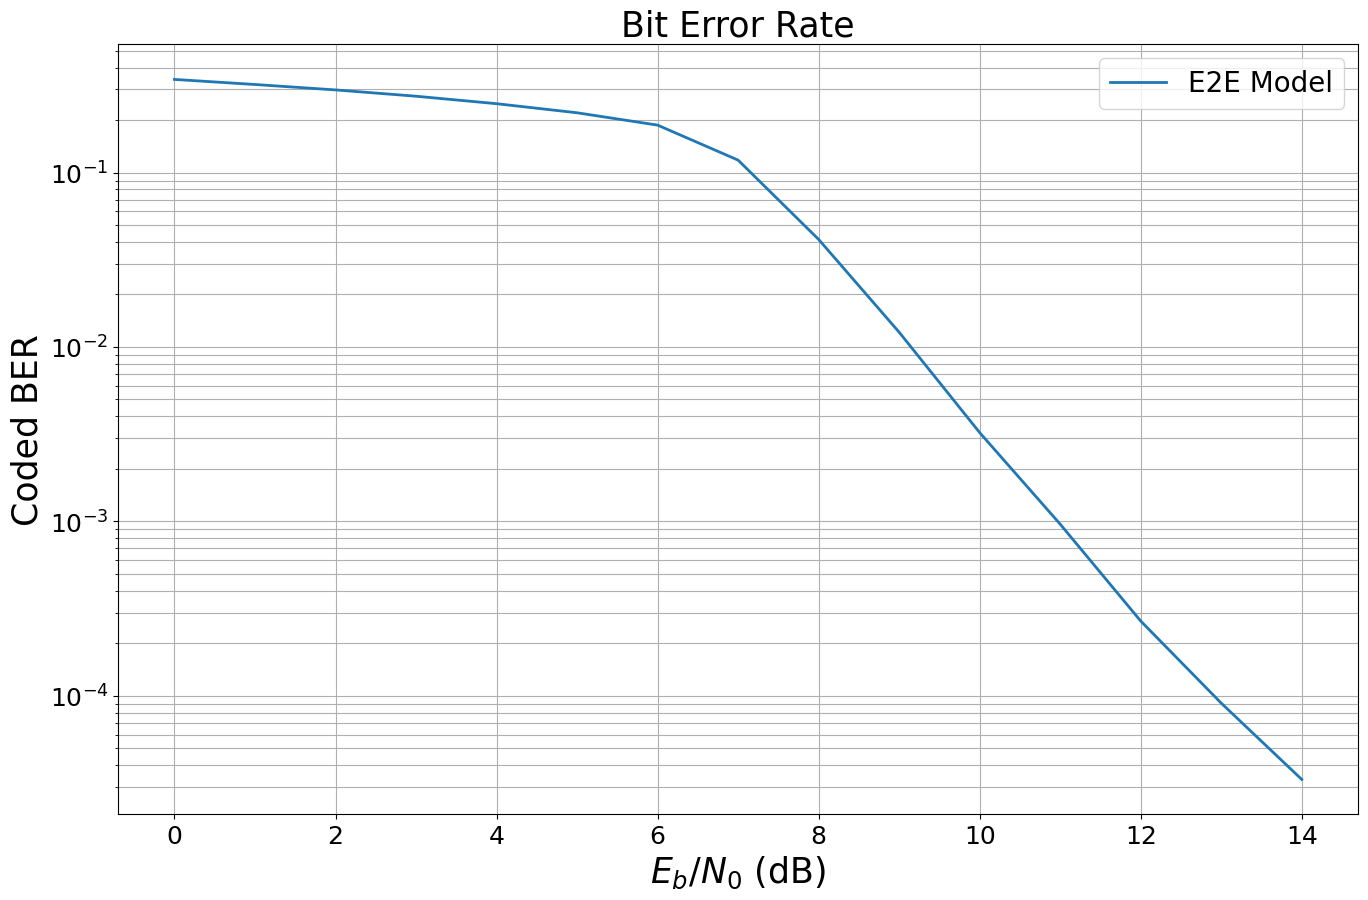

In [20]:
sionna.utils.plotting.plot_ber(ebno_dbs,
                               ber_mc,
                               legend="E2E Model",
                               ylabel="Coded BER");

### Conclusion

We hope you are excited about Sionna - there is much more to be discovered:

- TensorBoard debugging available
- Scaling to multi-GPU simulation is simple
- See the [available tutorials](https://nvlabs.github.io/sionna/tutorials.html) for more advanced examples.

And if something is still missing - the project is [open-source](https://github.com/nvlabs/sionna/):  you can modify, add, and extend any component at any time.